In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install bertopic

In [120]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import nltk
import spacy
import re
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import utils
from keras import layers
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import matplotlib
from matplotlib import pyplot as plt
from umap import UMAP
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from bertopic import BERTopic
from sklearn.cluster import KMeans
%matplotlib inline

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [118]:
url1 = '/content/drive/MyDrive/Макбук/Depression Detection/datasets depr/d.csv'
url2 = '/content/drive/MyDrive/Макбук/Depression Detection/datasets depr/non_d.csv'

In [119]:
d = pd.read_csv(url1)
non_d = pd.read_csv(url2)

In [15]:
d.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1261623711502753792,1261623711502753792,1.589630e+12,2020-05-16 01:45:07,-1000,NaN,the real reason why you're sad? you're attache...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1255537912491343872,1255537912491343872,1.588179e+12,2020-04-29 06:42:19,-1000,NaN,my biggest problem is overthinking everything,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1255524270521761792,1255524270521761792,1.588175e+12,2020-04-29 05:48:07,-1000,NaN,the worst sadness is the sadness you've taught...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1255524059334365186,1255524059334365186,1.588175e+12,2020-04-29 05:47:16,-1000,NaN,i cannot make you understand. i cannot make an...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1172463022100512769,1172463022100512769,1.568372e+12,2019-09-13 00:52:22,-1000,NaN,i don't think anyone really understands how ti...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


Checking which languages are presented

In [16]:
d['language'].value_counts()

en     3440
und      48
da        2
tr        1
tl        1
ja        1
ht        1
nl        1
fr        1
Name: language, dtype: int64

Leaving only English tweets for analysis

In [17]:
d = d[d['language'] == 'en']
non_d = non_d[non_d['language'] == 'en']


Adding a label column

In [18]:
d['label'] = [1 for i in range(0, d.shape[0])]
non_d['label'] = [0 for i in range(0, non_d.shape[0])]

In [19]:
d = d[['tweet', 'label']]
non_d = non_d[['tweet', 'label']]

Creating unified dataframe

In [20]:
data = pd.concat([d, non_d], axis = 0).reset_index(drop = True)

In [21]:
data.shape

(8135, 2)

Removing useless symbols from text


In [22]:
data['tweet'] = data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

Removing rows with less tha 10 symbols

In [23]:
data = data.drop(data[data.tweet.apply(lambda x: len(x.split()) < 10)].index)

In [24]:
data.shape

(5888, 2)

In [25]:
data.reset_index(drop=True, inplace=True)

In [26]:
data.index

RangeIndex(start=0, stop=5888, step=1)

In [27]:
data['tweet'].head()

0    the real reason why you're sad? you're attache...
1    the worst sadness is the sadness you've taught...
2    i cannot make you understand. i cannot make an...
3    i don't think anyone really understands how ti...
4    The worst feeling is when something is killing...
Name: tweet, dtype: object

## Text Preparation

Creating a function for tokenization

In [28]:
stop_words = []
def preprocess2(text, join_back=True):
    text = re.sub(r'http\S+', '', text)
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len = 1):
      if token not in gensim.parsing.preprocessing.STOPWORDS:
        result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [29]:
stop_words = []
def preprocess(text, join_back=True):
    text = re.sub(r'http\S+', '', text)
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len = 1):
        if token == 'm':
          result.append('am')
        elif token == 's':
          result.append('is')
        elif token == 've':
          result.append('have')
        elif token == 'd':
          result.append('had')
        elif token == 're':
          result.append('are')
        elif token == 'cannot':
          result.append('can not')
        elif token == 'don':
          result.append('do')
        elif token == 'doesn':
          result.append('do')
        elif token == 't':
          result.append('not')
          continue
        else:
          result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [30]:
idx = 10

print(
    f"Before : {data['tweet'].iloc[idx]}\n"
    f"After : {preprocess(data['tweet'].iloc[idx])}"
)

Before : Living with depression and anxiety  • no motivation to leave your      bed  • dreading leaving your house • not being able to go out • unable to make new friends • being paranoid or restless  • mentally hurting  • zoning out a lot, ignoring     people • not being yourself
After : living with depression and anxiety no motivation to leave your bed dreading leaving your house not being able to go out unable to make new friends being paranoid or restless mentally hurting zoning out a lot ignoring people not being yourself


In [31]:
data['tweet'] = data['tweet'].apply(preprocess)


## Text Visualisation

Word clouds for depressed and non depressed tweets

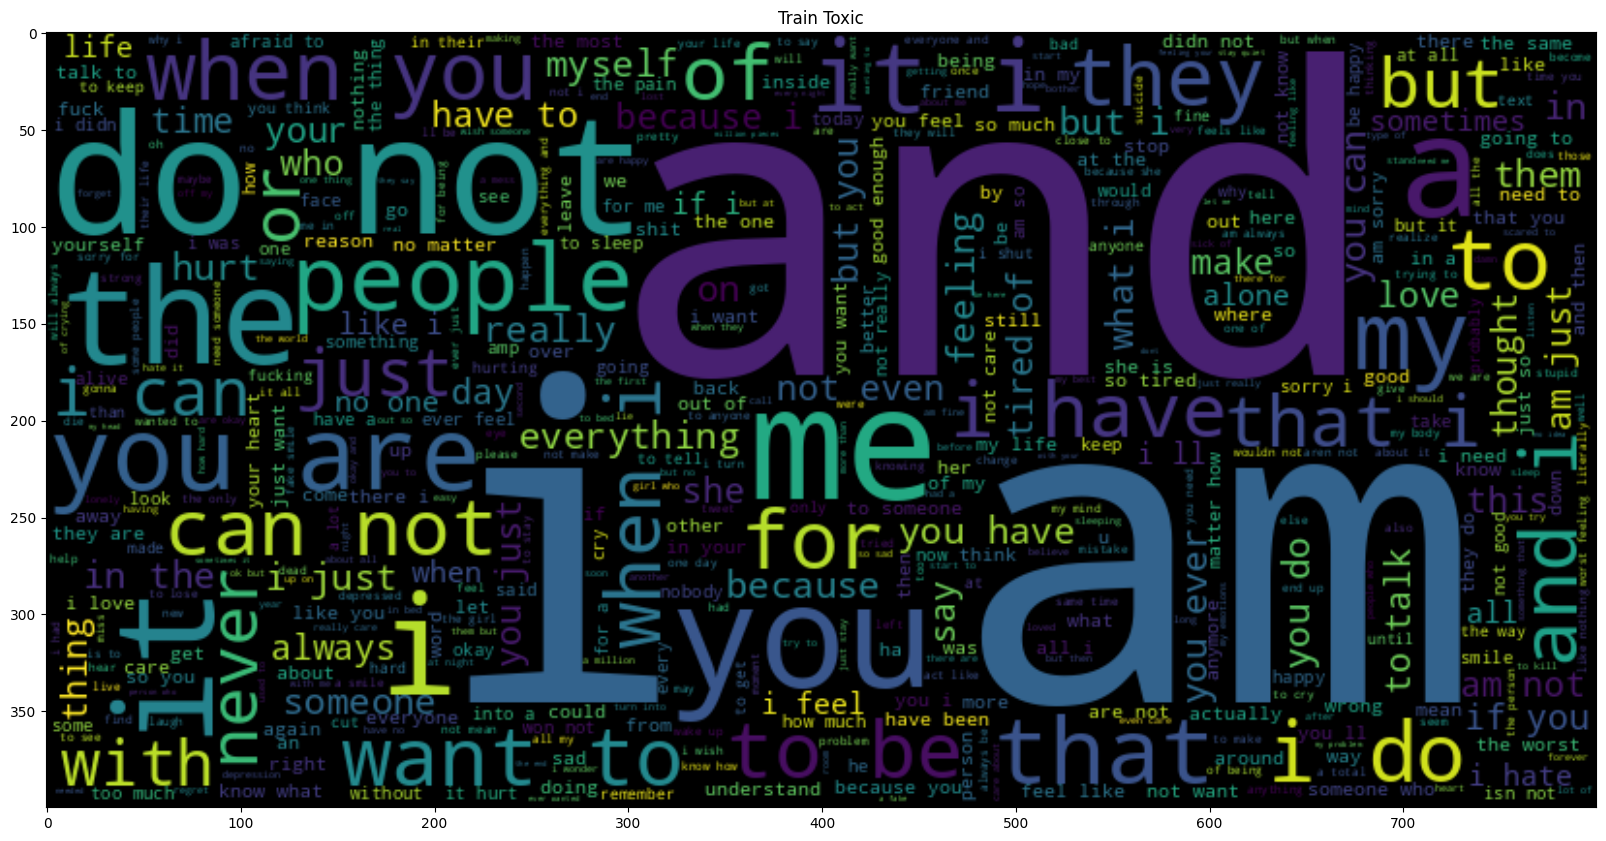

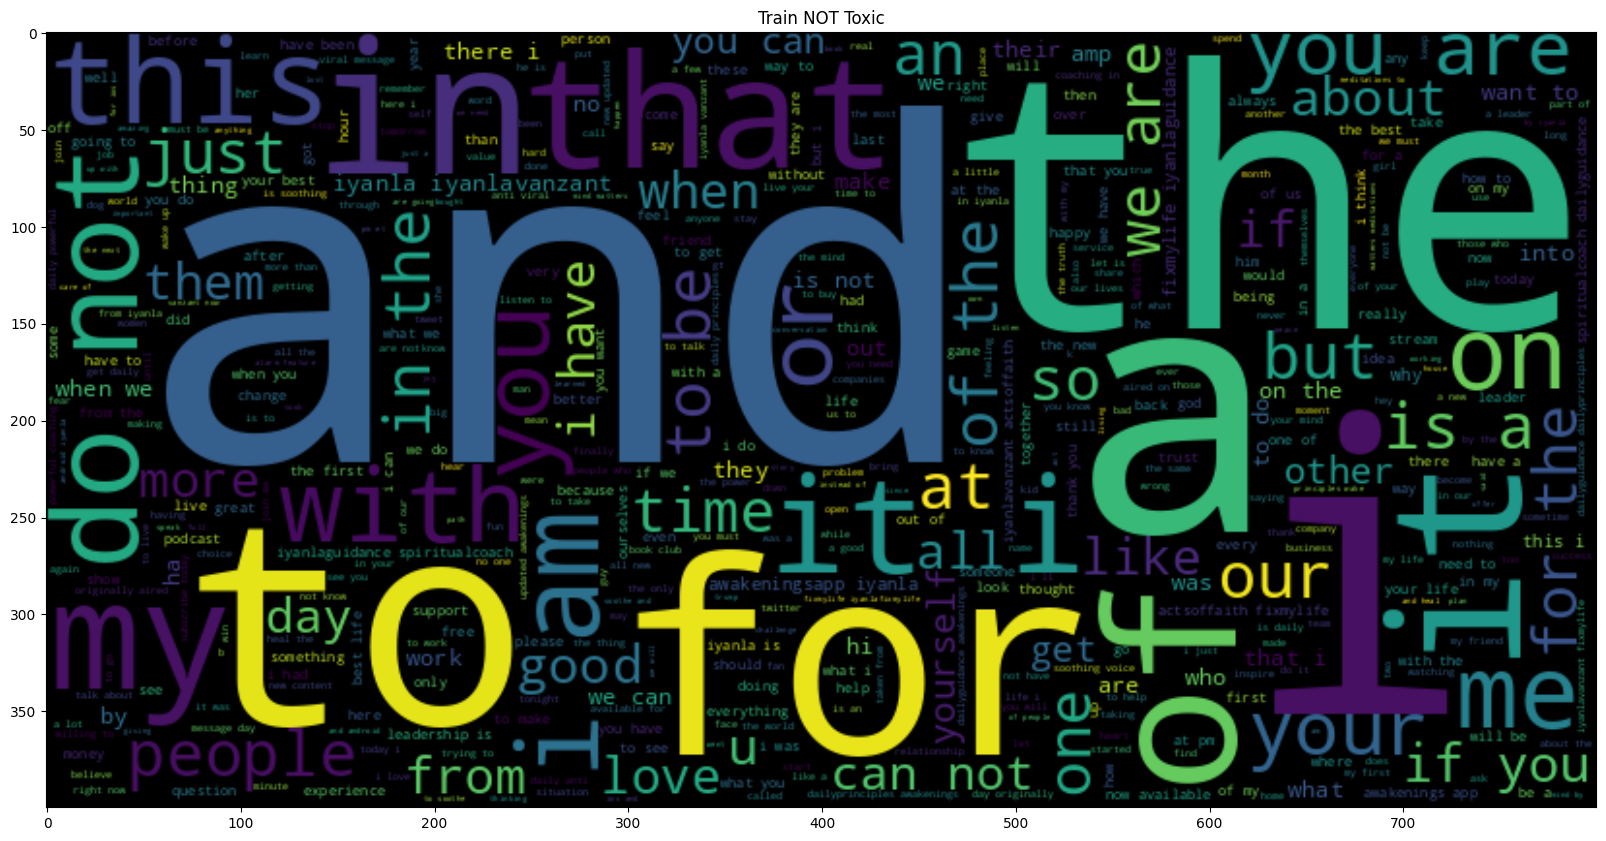

In [25]:
plt.figure(figsize = (20,20))
plt.title("Train Toxic")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(data[data['label'] == 1]['tweet']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20))
plt.title("Train NOT Toxic")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(data[data['label'] == 0]['tweet']))
plt.imshow(wc, interpolation = 'bilinear')

## Model Training

Bag of Words

In [32]:
X = data['tweet']
Y = data['label']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 300)

In [34]:
vector = CountVectorizer()
X_train_bag_of_words = vector.fit_transform(X_train)

In [35]:
vocabulary = vector.get_feature_names_out()

In [36]:
X_test_bag_of_words = CountVectorizer(vocabulary = vocabulary).transform(X_test)

In [37]:
y_train = y_train.values
y_test = y_test.values

Using logistic regression to predict depression

In [38]:
model = LogisticRegression()

In [39]:
all_train_pred = model.fit(
    X_train_bag_of_words, y_train
).predict(X_train_bag_of_words)


In [40]:
print(accuracy_score(y_train, all_train_pred))
print(precision_score(y_train, all_train_pred))
print(recall_score(y_train, all_train_pred))

0.9828025477707006
0.9882677708764666
0.9572192513368984


In [41]:
all_train_pred_d = model.predict(X_test_bag_of_words)


In [42]:
print(accuracy_score(y_test, all_train_pred_d))
print(precision_score(y_test, all_train_pred_d))
print(recall_score(y_test, all_train_pred_d))

0.8887945670628183
0.8742857142857143
0.7786259541984732


Sentence Transformer


Using transformers to tokenize data

In [ ]:
sent_tr = SentenceTransformer('all-mpnet-base-v2',device="cuda")

In [44]:
df = sent_tr.encode(data["tweet"].to_list())

In [45]:
Y = data['label']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state = 300)

In [47]:
model2 = LogisticRegression()

In [48]:
all_train_pred = model2.fit(
    X_train, y_train
).predict(X_train)


In [49]:
print(accuracy_score(y_train, all_train_pred))
print(precision_score(y_train, all_train_pred))
print(recall_score(y_train, all_train_pred))

0.9314225053078556
0.9150743099787686
0.8643048128342246


In [50]:
all_train_pred_d = model2.predict(X_test)


In [51]:
print(accuracy_score(y_test, all_train_pred_d))
print(precision_score(y_test, all_train_pred_d))
print(recall_score(y_test, all_train_pred_d))


0.9252971137521222
0.9066666666666666
0.8651399491094147


Building simple RNN

In [53]:
X = data['tweet']
Y = data['label']


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 300)

In [58]:
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = utils.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = utils.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
%%time
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [63]:
model.fit(xtrain_pad, y_train, epochs=5, batch_size=64*4)

Epoch 1/5
19/19 [==============================] - 47s 2s/step - loss: 0.5903 - accuracy: 0.6938
Epoch 2/5
19/19 [==============================] - 41s 2s/step - loss: 0.3014 - accuracy: 0.8964
Epoch 3/5
19/19 [==============================] - 37s 2s/step - loss: 0.1031 - accuracy: 0.9773
Epoch 4/5
19/19 [==============================] - 41s 2s/step - loss: 0.0255 - accuracy: 0.9970
Epoch 5/5
19/19 [==============================] - 39s 2s/step - loss: 0.0079 - accuracy: 1.0000


In [68]:
y_score = model.predict(xvalid_pad)

37/37 [==============================] - 10s 266ms/step


In [69]:
roc_auc_score(y_test, y_score)

0.9456378340707606

In [71]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)

In [73]:
roc_auc = metrics.auc(fpr, tpr)


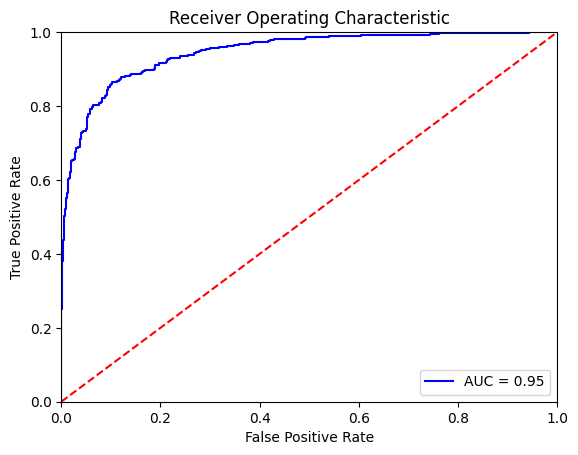

In [74]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [96]:
y_classes = (y_score > 0.5).astype(int)

In [97]:
print(accuracy_score(y_test, y_classes))
print(precision_score(y_test, y_classes))
print(recall_score(y_test, y_classes))

0.8845500848896435
0.8188585607940446
0.8396946564885496


Bi-Directional RNN

In [108]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         2877300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 3,198,301
Trainable params: 3,198,301
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.fit(xtrain_pad, y_train, epochs=5, batch_size=64*4)

Epoch 1/5
19/19 [==============================] - 14s 496ms/step - loss: 0.6048 - accuracy: 0.6879
Epoch 2/5
19/19 [==============================] - 9s 448ms/step - loss: 0.4321 - accuracy: 0.8550
Epoch 3/5
19/19 [==============================] - 10s 545ms/step - loss: 0.2359 - accuracy: 0.9191
Epoch 4/5
19/19 [==============================] - 9s 483ms/step - loss: 0.1443 - accuracy: 0.9490
Epoch 5/5
19/19 [==============================] - 9s 461ms/step - loss: 0.0898 - accuracy: 0.9732


In [110]:
y_score = model.predict(xvalid_pad)

37/37 [==============================] - 2s 39ms/step


In [111]:
roc_auc_score(y_test, y_score)

0.9638612016012708

In [112]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)

In [113]:
roc_auc = metrics.auc(fpr, tpr)


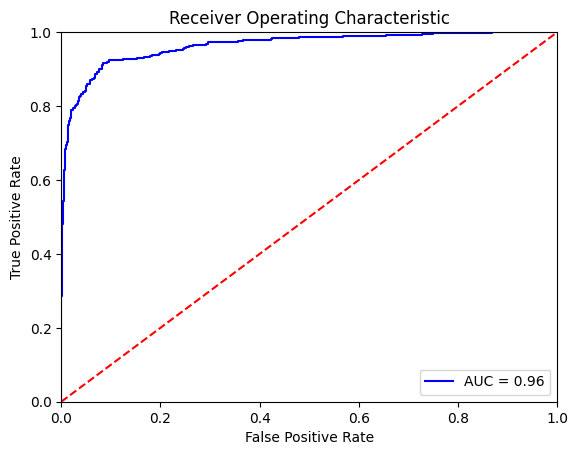

In [114]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [115]:
y_classes = (y_score > 0.5).astype(int)

In [116]:
print(accuracy_score(y_test, y_classes))
print(precision_score(y_test, y_classes))
print(recall_score(y_test, y_classes))

0.9168081494057725
0.9178470254957507
0.8244274809160306


##Topic Modelling using BERT

A list of stopwords is created manually because some
conventional stopwords may be useful

In [121]:
stpwrds = ['am', 'and', 'do', 'it', 'the', 'to', 'is', 'for', 'because', 'who', 'me', 'are', 'in', 'of', 'on']

In [103]:
#stop_words = stopwords.words('english')
stop_words = []
def preprocess3(text, join_back=True):
    text = re.sub(r'http\S+', '', text)
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len = 1):
        if token == 'm':
          result.append('am')
        elif token in stpwrds:
          continue
        elif token == 's':
          result.append('is')
        elif token == 've':
          result.append('have')
        elif token == 'd':
          result.append('had')
        elif token == 're':
          result.append('are')
        elif token == 'cannot':
          result.append('can not')
        elif token == 'don':
          result.append('do')
        elif token == 'doesn':
          result.append('do')
        elif token == 't':
          result.append('not')
          continue
        else:
          result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [105]:
depressed = data[data['label'] == 1]
depressed['tweet'] = depressed['tweet'].apply(preprocess3)
documents = [depressed['tweet'][i] for i in range(0, depressed.shape[0])]

In [106]:
model = BERTopic()

In [ ]:
topics, probs = model.fit_transform(documents)


In [108]:
depressed['topic'] = pd.Series(topics)

Checking topics for each tweet

In [109]:
depressed.head(15)

,tweet,label,topic
0,real reason why you sad you attached people ha...,1,-1
1,worst sadness sadness you have taught yourself...,1,-1
2,i can not make you understand i can not make a...,1,23
3,i not think anyone really understands how tiri...,1,10
4,worst feeling when something killing you insid...,1,-1
5,when i hurt i shut down i turn into a total bi...,1,45
6,over thinking ruins you ruins situation twists...,1,-1
7,i disappointed myself because i know i better ...,1,29
8,i just so tired this my body tired my mind a m...,1,0
9,i sick making things worse i sick being hurt i...,1,-1


In [ ]:
model.get_topic_freq()

Checking the most frequent words in each topic

In [112]:
model.get_topic_info()[['Topic', 'Count', 'Name', 'Representation']]


,Topic,Count,Name,Representation
0,-1,553,-1_not_you_that_just,"[not, you, that, just, can, because, when, my,..."
1,0,119,0_tired_sleep_bed_up,"[tired, sleep, bed, up, wake, sleeping, just, ..."
2,1,70,1_away_push_exist_stay,"[away, push, exist, stay, here, need, be, they..."
3,2,47,2_look_mirror_personality_prettier,"[look, mirror, personality, prettier, will, at..."
4,3,44,3_music_talk_silence_say,"[music, talk, silence, say, quiet, listen, und..."
5,4,44,4_smile_fake_haha_typing,"[smile, fake, haha, typing, cry, you, happy, a..."
6,5,40,5_happy_day_bad_happens,"[happy, day, bad, happens, give, be, fuck, whe..."
7,6,40,6_alone_there_lonely_ever,"[alone, there, lonely, ever, anyone, was, unlo..."
8,7,39,7_suicide_suicidal_die_myself,"[suicide, suicidal, die, myself, wanna, single..."
9,8,37,8_mistakes_regret_made_mistake,"[mistakes, regret, made, mistake, past, forget..."


The first group seems not to belong to any meaningful topic.
So the algorithm may be run sesveral types on tweets that
were categorized as topic -1

**Clustering**

Seeing how topic groups are located in the data space

In [ ]:
# Prepare data for plotting
embeddings = model._extract_embeddings(documents, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:5]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()

In [125]:
import random

In [126]:
gender = pd.Series([random.randint(0, 1) for i in range(0, len(documents))])
city = pd.Series([random.randint(0, 5) for i in range(0, len(documents))])
age = pd.Series([random.randint(1, 5) for i in range(0, len(documents))])
gender[:int(len(documents)/3)] = 1
age[:int(len(documents)/5)] = 0
age[:int(len(documents)/3)] = 1
age[:int(len(documents)/7)] = 2
age[:int(len(documents)/2)] = 3

In [127]:
depressed['gender'] = gender
depressed['city'] = city
depressed['age'] = age
depressed['topic'] = topics

Checking the distribution of topics by gender

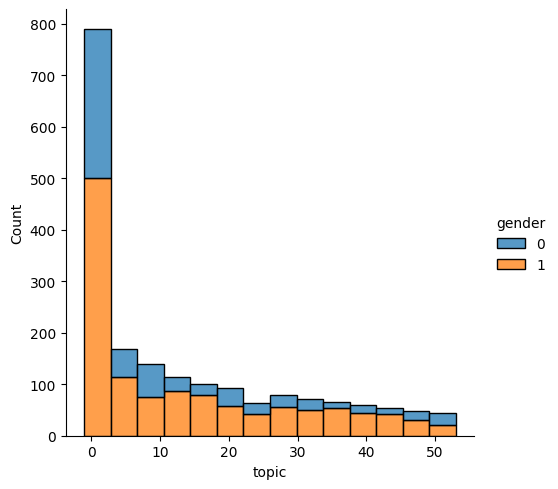

In [129]:
sns.displot(depressed, x="topic", hue="gender", multiple="stack")


### **END**